# Object Detection For Radar

## Imports

In [1]:
import os
import re
import cv2
import glob
import time
import json
import torch
import pickle
import random
import torchvision
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision.ops import box_iou
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from torchvision import models, transforms
from torch.nn.utils.rnn import pad_sequence
from transformers import DetrForObjectDetection
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from torchvision.models.detection import FasterRCNN
from sklearn.metrics import average_precision_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/hawk/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-12 15:29:02.583470: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 15:29:02.591163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 15:29:

## Data Loading

### Import config 

In [2]:
def load_config(config_path):
    """Load paths and info from config file"""
    with open(config_path, 'r') as config_file:
        content = config_file.read()
        if not content.strip():
            raise ValueError("Configuration file is empty")
        config = json.loads(content)
    return config


config_path = "/home/hawk/Desktop/objectDetection/Object_detection/configs/config.json"
config = load_config(config_path)

# all data
train_path = config["train_path"]
test_path = config["test_path"]

# example (only part 9, which is the smallest)
example_RAD_folder_path = config["example_RAD_folder_path"]
example_stereo_folder_path = config["example_stereo_folder_path"]
example_GT_folder_path = config["example_GT_folder_path"]

### Load RADDet data (or paths)

In The RADDet dataset, the data has 3 forms 
- RAD: Range Azimuth Doppler data in npy files.
- gt: Ground truth - a dict containing classes, boxes and cartesian boxes saved in pickle files.
- stereo images: images in png files.

*here we print the properties of part 9 from the RADDet dataset, which is the smallest part for fast loading and understanding*

In [3]:
# Numpy files
RAD_files_paths = [os.path.join(example_RAD_folder_path, file) for file in os.listdir(example_RAD_folder_path) if file.endswith('.npy')]
example_RAD_files = [np.load(file) for file in RAD_files_paths]
print(' ---- RAD ----')
print(f'Number of RAD files loaded: {len(example_RAD_files)}')
print(f'Each RAD file is of size: {example_RAD_files[0].shape} which stands for: (Range, Azimuth, Doppler)')
print('\n')

# Ground truth files
GT_files_paths = [os.path.join(example_GT_folder_path, file) for file in os.listdir(example_GT_folder_path) if file.endswith('.pickle')]
example_GT_files = []
for file in GT_files_paths:
    with open(file, 'rb') as f:
        example_GT_files.append(pickle.load(f))
print(' ---- GT ----')
print(f'Number of GT files loaded: {len(example_GT_files)}')
print(f'Each GT file is a dict with length 3: classes, boxes and cart_boxes. An example:')
print(example_GT_files[0])
print('\n')

# Stereo image files
stereo_files_paths = [os.path.join(example_stereo_folder_path, file) for file in os.listdir(example_stereo_folder_path) if file.endswith('.jpg')]
example_stereo_files = [Image.open(file).convert('RGB') for file in stereo_files_paths]
print(' ---- Stereo ----')
print(f'Number of loaded images: {len(example_stereo_files)}')


 ---- RAD ----
Number of RAD files loaded: 126
Each RAD file is of size: (256, 256, 64) which stands for: (Range, Azimuth, Doppler)


 ---- GT ----
Number of GT files loaded: 126
Each GT file is a dict with length 3: classes, boxes and cart_boxes. An example:
{'classes': ['truck', 'car', 'car', 'car'], 'boxes': array([[177.5, 173. ,  30. ,  28. ,  51. ,  25. ],
       [202. , 217.5,  32. ,   9. ,  34. ,  17. ],
       [ 66. ,  95. ,  40.5,   5. ,   7. ,   4. ],
       [ 15.5,  89.5,  38. ,   4. ,   8. ,   5. ]]), 'cart_boxes': array([[183.5, 283.5,  30. ,  30. ],
       [218. , 290.5,  19. ,  10. ],
       [ 72.5, 206. ,   6. ,  11. ],
       [ 26.5, 183. ,   8. ,  13. ]])}


 ---- Stereo ----
Number of loaded images: 126


### Load all data function

this function can get all paths, or load all the data to memory.

loading the data is not recommended, it can only be good for small datasets. therefore the default is getting the paths.

i added the option for testing and understanding, do not use for the full RADDet or CARRADA

In [4]:
# Note- this function is very specific to the folder structure in the RADDet dataset and will
# not fit to others (probably)
def load_all_data(data_path, subfolder, file_type, load_all=False):
    """
    Loads or retrieves file paths from a specified directory.

    Parameters:
    - data_path (str): The root directory containing the data (e.g., train or test).
    - subfolder (str): The specific subfolder to search within (e.g., 'RAD', 'gt', or 'stereo_image').
    - file_type (str): The type of files to load or retrieve paths for (e.g., '.npy', '.pickle', or '.jpg').
    - load_all (bool): If True, loads all files into memory. If False, returns file paths only for lazy loading. Default is False.

    Returns:
    - list: A list of file paths if load_all is False, or a list of loaded data objects if load_all is True.
    """
    loaders = {
        '.npy': np.load,
        '.pickle': lambda filepath: pickle.load(open(filepath,'rb')),
        '.jpg': Image.open
    }

    loader = loaders.get(file_type)
    if loader is None:
        raise ValueError(f"file type is unassigned or unsupported.")
    
    data = []
    data_path = os.path.join(data_path, subfolder)
    for root, subdirs, files in os.walk(data_path):
        for filename in files:
            if filename.endswith(file_type):
                filepath = os.path.join(root, filename)
                if load_all:
                    data.append(loader(filepath))
                else:
                    data.append(filepath)

    return data

### Load & Sort Path For Lazy Loading

In [5]:
train_RAD_paths = load_all_data(train_path, 'RAD', '.npy', False) 
train_GT_paths = load_all_data(train_path, 'gt', '.pickle', False)
train_stereo_paths = load_all_data(train_path, 'stereo_image', '.jpg', False)
test_RAD_paths = load_all_data(test_path, 'RAD', '.npy', False) 
test_GT_paths = load_all_data(test_path, 'gt', '.pickle', False)
test_stereo_paths = load_all_data(test_path, 'stereo_image', '.jpg', False)

In [6]:
def extract_number(path):
    """Extract the serial number from the data, so we can pair the right RAD gt and images together"""
    filename = os.path.basename(path)
    number = re.search(r'\d+', filename).group()
    return number
#print(extract_number(train_stereo_paths[0]))

In [7]:
train_RAD_paths = sorted(train_RAD_paths, key=extract_number)
train_GT_paths = sorted(train_GT_paths, key=extract_number)
train_stereo_paths = sorted(train_stereo_paths, key=extract_number)
test_RAD_paths = sorted(test_RAD_paths, key=extract_number)
test_GT_paths = sorted(test_GT_paths, key=extract_number)
test_stereo_paths = sorted(test_stereo_paths, key=extract_number)

## RADDet Preprocessing functions

### handle gt files

In [8]:
def read_and_encode_GtRD(gt_instance, rd_shape):
    """
    converts ground truth format to be compatible with the RD maps for faster RCNN.

    Returns:
    - new_boxes (list): A list of converted bounding boxes in the format [y1, x1, y2, x2]
    - new_classes (list): A list of class labels corresponding to the new bounding boxes.

    the original bounding box is in [x_center, y_center, z_center, w, h, d] format because the RAD tensors are cubes.
    we are only interested in [x_center, _, z_center, w, _, d] where x is the range and z is the doppler. so we take:
    yc, xc, h, w = box[0], box[2], box[3], box[5] and change it to be represented by the edges
    """
    boxes = gt_instance["boxes"]
    classes = gt_instance["classes"]
    new_boxes = []
    new_classes = []
    
    for (box, class_) in zip(boxes, classes):
        yc, xc, h, w = box[0], box[2], box[3], box[5]
        y1, y2, x1, x2 = int(yc - h / 2), int(yc + h / 2), int(xc - w / 2), int(xc + w / 2)
        new_boxes.append([y1 , x1, y2 , x2])
        new_classes.append(class_)
    return new_boxes, new_classes

### RAD to RD functions

In [9]:
def complex_to_2_channels(target_array):
    """converts a complex array to a magnitude array and applies log"""
    assert target_array.dtype == np.complex64
    output_array = get_magnitude(target_array)
    output_array = get_log(output_array)
    return output_array

def get_magnitude(target_array, power_order=2):
    """calculates the magnitude of a complex array raised to a power"""
    target_array = np.abs(target_array)
    target_array = pow(target_array, power_order)
    return target_array

def get_log(target_array, scalar=1., log_10=True):
    """apply log(base10)"""
    if log_10:
        return scalar * np.log10(target_array + 1.)
    else:
        return target_array

def get_sum_dim(target_array, target_axis):
    """sums the elements of the array along the azimuth axis"""
    output = np.sum(target_array, axis=target_axis)
    return output

### Min and Max values for normalization

In [10]:
def get_max_min_vals(RAD_paths):
    max_val = 0
    min_val = 100000 #some large number..
    for sample in train_RAD_paths:
        loaded_sample = np.load(sample)
        current_max = np.max(np.abs(loaded_sample))
        current_min = np.min(np.abs(loaded_sample))
        if current_max>max_val:
            max_val = current_max
        if current_min<min_val:
            min_val = current_min
    return min_val, max_val
#glob_min_val, glob_max_val = get_max_min_vals(train_GT_paths)
#print(glob_min_val, glob_max_val)

## Custom Dataset

In [11]:
class Lazy_RaddetDataset(Dataset):
    """Custom Dataset for RADDet dataset"""
    
    def __init__(self, RAD_paths, GT_paths, transform=None):
        self.transform = transform
        self.classes_list = ["person", "bicycle", "car", "motorcycle", "bus", "truck"]
        self.RAD_paths = RAD_paths
        self.GT_paths = GT_paths

        # found with the get_max_min_vals function
        self.global_max = 252821.64
        self.global_min = 0.0

    def __len__(self):
        return len(self.RAD_paths)
    
    def __getitem__(self, idx):
        
        RAD_complex = np.load(self.RAD_paths[idx]) 
        RAD_data = complex_to_2_channels(RAD_complex)
        RAD_data = RAD_data / self.global_max
        RD_data = get_sum_dim(RAD_data, target_axis=1)

        with open(self.GT_paths[idx], 'rb') as file:
            gt_instances = pickle.load(file)
        bboxes, classes = read_and_encode_GtRD(gt_instances, RD_data.shape)
        
        objects = []
        for box, class_ in zip(bboxes, classes):
            ymin, xmin, ymax, xmax = box
            
            # Check if the bounding box has positive width and height
            if xmax > xmin and ymax > ymin:
                objects.append({
                    'bbox': torch.tensor([xmin, ymin, xmax, ymax], dtype=torch.float32),
                    'label': torch.tensor(self.classes_list.index(class_) + 1, dtype=torch.int64)  # +1 because background is 0
                })
            
            #else:
            #    print(f"Skipping invalid box {box} for target at index {idx}")

        # RD_data is now treated as the image
        spectrum_image = torch.tensor(RD_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        
        sample = {
            'spectrum': spectrum_image,
            'spectrum_filename': self.RAD_paths[idx],
            'gt_filename': self.GT_paths[idx],
            'objects': objects
        }
        
        if self.transform:
            sample = self.transform(sample)
        
        if len(sample['objects']) == 0:
            # If no valid objects, return an empty tensor for boxes and labels
            return sample['spectrum'], {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros((0,), dtype=torch.int64)
            }
        
        return sample['spectrum'], {
            "boxes": torch.stack([o['bbox'] for o in sample['objects']]),
            "labels": torch.tensor([o['label'] for o in sample['objects']], dtype=torch.int64)
        }


## Faster R-CNN

In [12]:
dataset = Lazy_RaddetDataset(train_RAD_paths, train_GT_paths)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

test_dataset = Lazy_RaddetDataset(test_RAD_paths, test_GT_paths)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier 
num_classes = len(dataset.classes_list) + 1  # +1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 100


In [14]:
def calculate_mAP(model, dataloader, device):
    model.eval()
    all_ious = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)
            
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu()
                gt_boxes = targets[i]['boxes'].cpu()

                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    ious = box_iou(pred_boxes, gt_boxes)
                    all_ious.append(ious.mean().item())

    return sum(all_ious) / len(all_ious) if all_ious else 0.0

In [15]:
epoch_losses = []
epoch_mAPs = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    i = 0
    for spectrum_images, targets in dataloader:
        spectrum_images = list(img.to(device) for img in spectrum_images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(spectrum_images, targets)

        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 1000 == 0:
            loss_details = ', '.join([f'{k}: {v.item():.4f}' for k, v in loss_dict.items()])
            print(f"Epoch [{epoch}/{num_epochs}], Iteration [{i}/{len(dataloader)}], Losses: {loss_details}, Total Loss: {losses.item():.4f}")
        i += 1

    epoch_losses.append(epoch_loss / len(dataloader))

    lr_scheduler.step()

    mAP = calculate_mAP(model, dataloader, device)
    epoch_mAPs.append(mAP)
    print(f"Epoch [{epoch}/{num_epochs}] mAP: {mAP:.4f}")

print("Training complete.")

Epoch [0/100], Iteration [0/2032], Losses: loss_classifier: 2.1691, loss_box_reg: 0.0133, loss_objectness: 0.6570, loss_rpn_box_reg: 0.0282, Total Loss: 2.8675
Epoch [0/100], Iteration [1000/2032], Losses: loss_classifier: 0.0250, loss_box_reg: 0.0001, loss_objectness: 0.1780, loss_rpn_box_reg: 0.0469, Total Loss: 0.2500
Epoch [0/100], Iteration [2000/2032], Losses: loss_classifier: 0.2187, loss_box_reg: 0.0649, loss_objectness: 0.1930, loss_rpn_box_reg: 0.0423, Total Loss: 0.5189
Epoch [0/100] mAP: 0.0310
Epoch [1/100], Iteration [0/2032], Losses: loss_classifier: 0.1023, loss_box_reg: 0.0592, loss_objectness: 0.2436, loss_rpn_box_reg: 0.0741, Total Loss: 0.4791
Epoch [1/100], Iteration [1000/2032], Losses: loss_classifier: 0.0571, loss_box_reg: 0.0167, loss_objectness: 0.2087, loss_rpn_box_reg: 0.1190, Total Loss: 0.4015
Epoch [1/100], Iteration [2000/2032], Losses: loss_classifier: 0.1173, loss_box_reg: 0.0953, loss_objectness: 0.1073, loss_rpn_box_reg: 0.0549, Total Loss: 0.3747
Ep

In [ ]:
torch.save(model.state_dict(), '/home/hawk/Desktop/objectDetection/Object_detection/models/100_model_weights.pth')

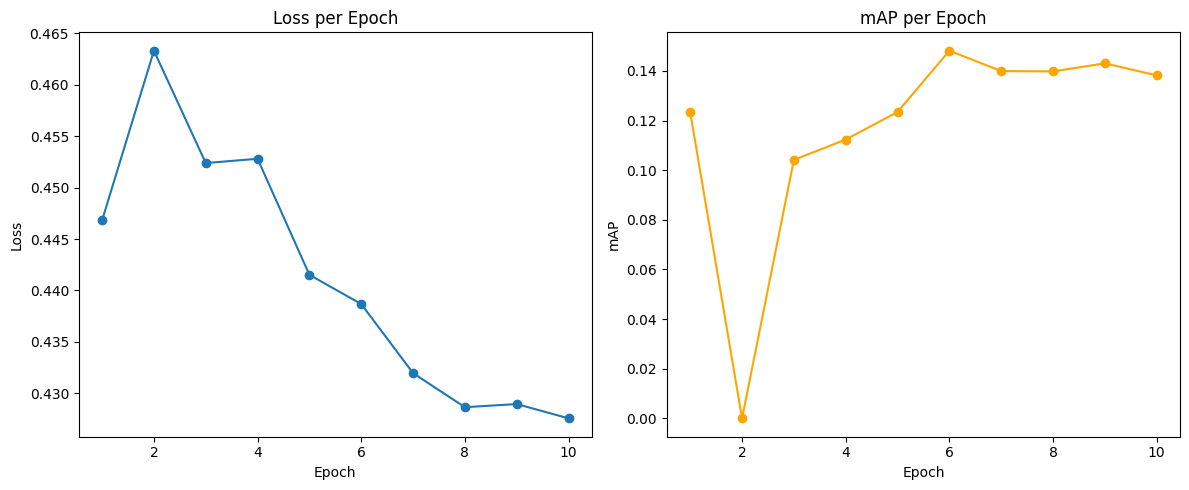

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_mAPs, marker='o', color='orange')
plt.title('mAP per Epoch')
plt.xlabel('Epoch')
plt.ylabel('mAP')

plt.tight_layout()
plt.show()


tensor([77])


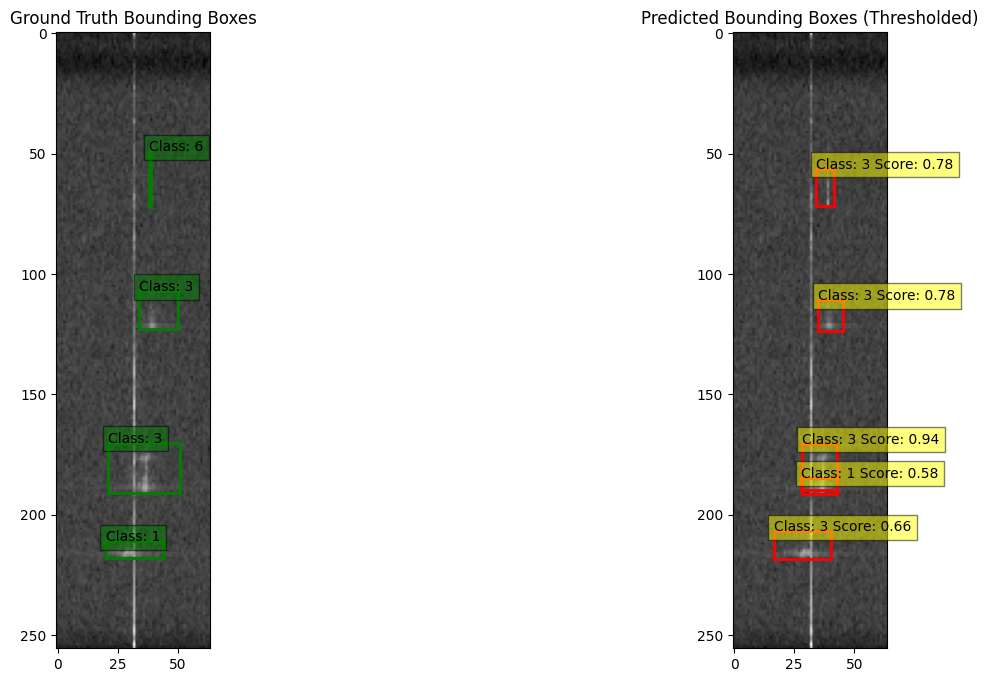

In [ ]:
model.eval()
rand_num = torch.randint(0, 100, (1,))
print(rand_num)
test_sample_idx = rand_num.item()
spectrum_image, target = test_dataset[test_sample_idx]

# Ensure the image has the correct shape [C, H, W]
if spectrum_image.ndimension() == 2:  
    spectrum_image = spectrum_image.unsqueeze(0)  

spectrum_image = spectrum_image.to(device)

with torch.no_grad():
    prediction = model([spectrum_image])[0]
pred_boxes = prediction['boxes'].cpu().numpy()
pred_labels = prediction['labels'].cpu().numpy()
pred_scores = prediction['scores'].cpu().numpy()

gt_boxes = target['boxes'].numpy()
gt_labels = target['labels'].numpy()

spectrum_image = spectrum_image.cpu().numpy()

threshold = 0.5
keep = pred_scores >= threshold
pred_boxes = pred_boxes[keep]
pred_labels = pred_labels[keep]
pred_scores = pred_scores[keep]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(spectrum_image[0], cmap='gray')
for box, label in zip(gt_boxes, gt_labels):
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='g', facecolor='none')
    ax1.add_patch(rect)
    ax1.text(xmin, ymin, f'Class: {label}', bbox=dict(facecolor='green', alpha=0.5))

ax1.set_title('Ground Truth Bounding Boxes')

ax2.imshow(spectrum_image[0], cmap='gray')
for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
    ax2.text(xmin, ymin, f'Class: {label} Score: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

ax2.set_title('Predicted Bounding Boxes (Thresholded)')
plt.show()
